In [1]:
%pylab inline
%load_ext version_information

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division, print_function
from IPython.core.display import Image
from deltasigma import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.set_printoptions(suppress=True, precision=3)

Delta Sigma modulator synthesis - example #1
============================================

Demonstration of the synthesis of an example delta sigma modulator,  as done in the `MATLAB Delta Sigma Toolbox`, employing its Python port `deltasigma`.

 * The **Noise Transfer Function** (NTF) is synthesized for a **5th-order**, **low-pass** modulator, having the following characteristics:

     * A relatively low Over Sampling Ratio (OSR), equal to `32`, 
     * A 1-bit quantizer. 
     * Maximum NTF gain equal to 1.5.

 * For this example modulator, we select to implement the CRFB topology -- see below, for order being odd -- with a single feed-in, ie $b_n = 0\ \forall n > 1$ .

In [4]:
Image(url='http://python-deltasigma.readthedocs.org/en/latest/_images/CRFB.png', retina=True)

## Set up the parameters

In [5]:
order = 5
osr = 32
nlev = 2
f0 = 0.
Hinf = 1.5
form = 'CRFB'

## Synthesize the NTF

In [6]:
ntf = synthesizeNTF(order, osr, 2, Hinf, f0)            # Optimized zero placement
print("Synthesized a %d-order NTF, with roots:\n" % order)
print(" Zeros:\t\t\t Poles:")
for z, p in zip(ntf[0], ntf[1]):
    print("(%f, %fj)\t(%f, %fj)" % (np.real(z), np.imag(z), np.real(p), np.imag(p)))
print("")
print("The NTF transfer function has the following expression:\n")
print(pretty_lti(ntf))
print("")

Synthesized a 5-order NTF, with roots:

 Zeros:			 Poles:
(1.000000, 0.000000j)	(0.806557, -0.119823j)
(0.998603, 0.052839j)	(0.806557, 0.119823j)
(0.998603, -0.052839j)	(0.898071, -0.219819j)
(0.996045, 0.088847j)	(0.898071, 0.219819j)
(0.996045, -0.088847j)	(0.777767, 0.000000j)

The NTF transfer function has the following expression:

      (z^2 - 1.992z + 0.9999) (z^2 - 1.997z + 1) (z - 1)     
-------------------------------------------------------------
 (z^2 - 1.613z + 0.665) (z^2 - 1.796z + 0.8549) (z - 0.7778) 



### Graphical inspection of the synthesized singularities

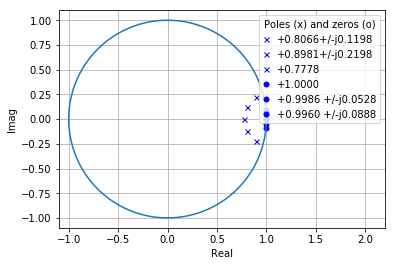

In [7]:
plotPZ(ntf, showlist=True)

## Realize the NTF with the CRFB topology and create the ABCD representation

In [8]:
a, g, b, c = realizeNTF(ntf, form)
b = np.hstack(( # Use a single feed-in for the input
               np.atleast_1d(b[0]),
               np.zeros((b.shape[0] - 1, ))
             ))
ABCD = stuffABCD(a, g, b, c, form)
print("ABCD Matrix:")
print(ABCD)

ABCD Matrix:
[[ 1.     0.     0.     0.     0.     0.001 -0.001]
 [ 1.     1.    -0.003  0.     0.     0.    -0.008]
 [ 1.     1.     0.997  0.     0.     0.    -0.063]
 [ 0.     0.     1.     1.    -0.008  0.    -0.244]
 [ 0.     0.     1.     1.     0.992  0.    -0.802]
 [ 0.     0.     0.     0.     1.     0.     0.   ]]


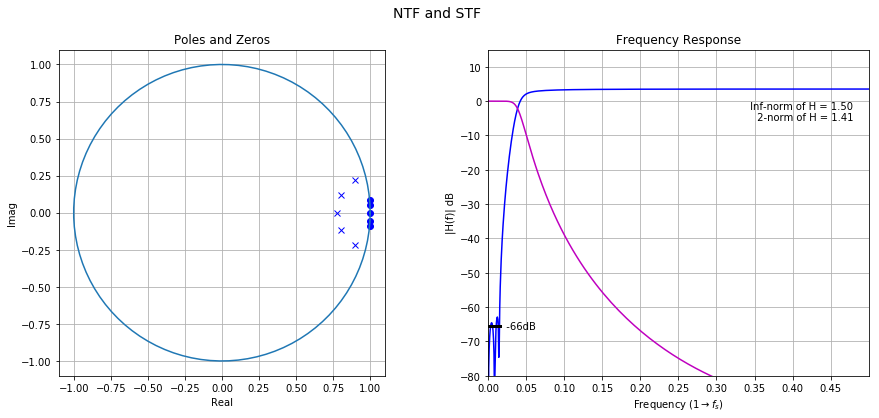

In [9]:
DocumentNTF(ABCD, osr, f0)
f = gcf()
f.set_size_inches((15, 6))

## Typical spectral characteristics

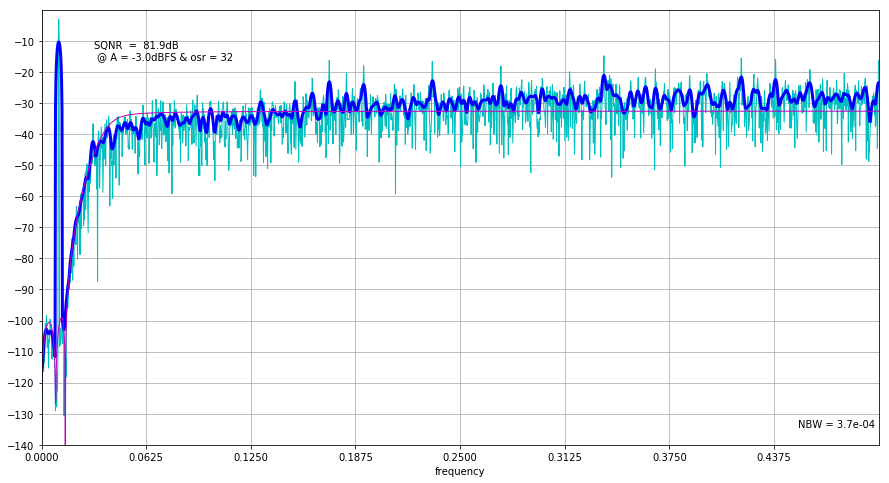

In [10]:
figure(figsize=(15,8))
PlotExampleSpectrum(ntf, M=1, osr=osr, f0=f0)

## Signal to Noise Ratio analysis

In [11]:
snr, amp = simulateSNR(ntf, osr, None, f0, nlev)

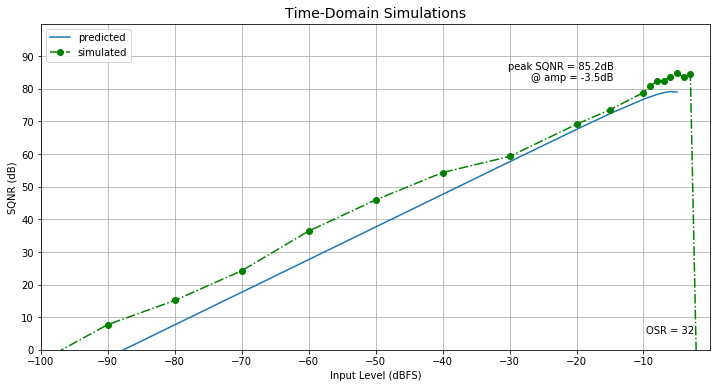

In [12]:
figure(figsize=(15,8))
if nlev == 2:
    snr_pred, amp_pred, k0, k1, se = predictSNR(ntf, osr)
    plot(amp_pred, snr_pred, '-', label='predicted')
    hold(True)
plot(amp, snr,'o-.g', label='simulated')
xlabel('Input Level (dBFS)')
ylabel('SQNR (dB)')
peak_snr, peak_amp = peakSNR(snr, amp)
msg = 'peak SQNR = %4.1fdB  \n@ amp = %4.1fdB  ' % (peak_snr, peak_amp)
text(peak_amp-10,peak_snr,msg, horizontalalignment='right', verticalalignment='center');
msg = 'OSR = %d ' % osr
text(-2, 5, msg, horizontalalignment='right');
hold(False)
figureMagic([-100, 0], 10, None, [0, 100], 10, None, [12, 6], 'Time-Domain Simulations')
legend(loc=2);

## Dynamic range scaling

Keep the integrator outputs within their working range -- to avoid waveform clipping and instabilities.

The ABCD matrix is scaled opportunely, then the effectiveness of the dynamic range scaling is verified and the state maxima are plotted for different amplitudes.

In [13]:
print('Doing dynamic range scaling... ')
ABCD0 = ABCD.copy()
ABCD, umax, S = scaleABCD(ABCD0, nlev, f0)
print('Done.')
print("Maximum input magnitude: %.3f" % umax)

Doing dynamic range scaling... 
Done.
Maximum input magnitude: 0.583


In [14]:
print('Verifying dynamic range scaling... ')
u = np.linspace(0, 0.95*umax, 30)
N = 1e4
N0 = 50
test_tone = np.cos(2*np.pi*f0*np.arange(N))
test_tone[:N0] = test_tone[:N0]*(0.5 - 0.5*np.cos(2*np.pi/N0*np.arange(N0)))
maxima = np.zeros((order, u.shape[0]))
for i in np.arange(u.shape[0]):
    ui = u[i]
    v, xn, xmax, y = simulateDSM(ui*test_tone, ABCD, nlev)
    maxima[:, i] = xmax[:, 0]
    if (xmax > 1e2).any(): 
        print('Warning, umax from scaleABCD was too high.')
        umax = ui
        u = u[:i]
        maxima = maxima[:, :i]
        break
print('Done.')
print("Maximum DC input level: %.3f" % umax)

Verifying dynamic range scaling... 
Done.
Maximum DC input level: 0.583


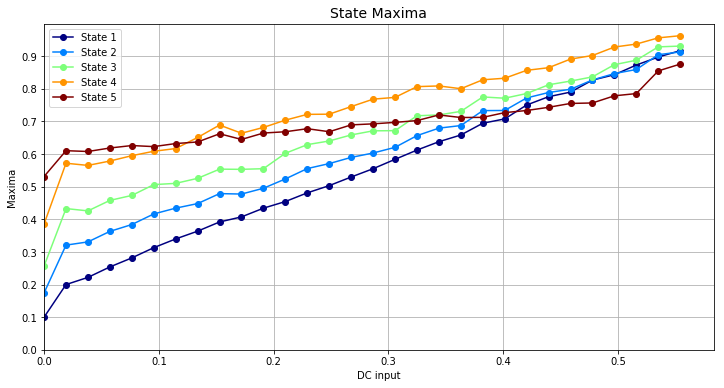

In [15]:
colors = get_cmap('jet')(np.linspace(0, 1.0, order))
hold(True)
for i in range(order):
    plot(u,maxima[i,:], 'o-', color=colors[i], label='State %d' % (i+1))
grid(True)
#text(umax/2, 0.05, 'DC input', horizontalalignment='center', verticalalignment='center')
figureMagic([0, umax], None, None, [0, 1] , 0.1, 2, [12, 6], 'State Maxima')
xlabel('DC input')
ylabel('Maxima')
legend(loc='best');

## Conclusions
### Scaled coefficients

In [16]:
a, g, b, c = mapABCD(ABCD, form)

In [17]:
adc = {
       'order':order,
       'osr':osr,
       'nlev':nlev,
       'f0':f0,
       'ntf':ntf,
       'ABCD':ABCD,
       'umax':umax,
       'peak_snr':peak_snr,
       'form':form,
       'coefficients':{
                       'a':a,
                       'g':g,
                       'b':b,
                       'c':c
                      }
      }

### Final ADC coefficients

In [18]:
t_sz = max([len(adc['coefficients']['a']), len(adc['coefficients']['g']), \
            len(adc['coefficients']['b']), len(adc['coefficients']['c'])])
t_nan = [np.nan for x in range(t_sz)]
t = {'Coefficients' : ['#1', '#2', '#3', '#4', '#5', '#6'],
     'DAC feedback: a(n)' : (adc['coefficients']['a'].tolist()+t_nan)[:t_sz],
     'Resonator feedback: g(n)' : (adc['coefficients']['g'].tolist()+t_nan)[:t_sz],
     'Feed-in: b(n)' : (adc['coefficients']['b'].tolist()+t_nan)[:t_sz],
     'Interstage: c(n)' : (adc['coefficients']['c'].tolist()+t_nan)[:t_sz]}
pd.DataFrame(t)

,Coefficients,DAC feedback: a(n),Feed-in: b(n),Interstage: c(n),Resonator feedback: g(n)
0,#1,0.099971,0.099971,0.137200,0.014663
1,#2,0.170091,0.000000,0.190547,0.017975
2,#3,0.212593,0.000000,0.383916,NaN
3,#4,0.362915,0.000000,0.440024,NaN
4,#5,0.364635,0.000000,1.530105,NaN
5,#6,NaN,0.000000,NaN,NaN


### System version information

In [19]:
%version_information numpy, scipy, matplotlib, deltasigma, cython

Software versions
Python 3.6.8 64bit [GCC 8.3.0]
IPython 5.5.0
OS Linux 5.0.0 36 generic x86_64 with Ubuntu 18.04 bionic
numpy 1.13.3
scipy 0.19.1
matplotlib 2.1.1
deltasigma 0.2.3rc1
cython 0.26.1
Thu Nov 28 11:10:45 2019 CST